# Simulated TFEA vs. AME Comparison

This Jupyter notebook walks through the generation of simulated data for the comparison of TFEA and AME.

# Table of Contents
1. [Initialize](#Initialize)<br>
2. [Generate Simulated Data for Tests](#Generate-Simulated-Data-for-Tests)<br>
    2.1 [Signal to Noise Dataset](#Signal-to-Noise-Dataset)<br>
    2.2 [Variance to Noise Dataset](#Variance-to-Noise-Dataset)<br>
    2.3 [Runtime Comparison Dataset](#Runtime-Comparison-Dataset)<br>
    2.4 [Memory Usage Dataset](#Memory-Usage-Dataset)<br>
3. [Main Figure](#Main-Figure)<br>
    3.1 [False Positive and True Positive Rates per Cutoff](#False-Positive-and-True-Positive-Rates-per-Cutoff)<br>
    3.2 [Signal to Noise F1-Score Calculation](#Signal-to-Noise-F1-Score-Calculation)<br>
    3.3 [Variance to Noise F1-Score Calculation](#Variance-to-Noise-F1-Score-Calculation)<br>
4. [Supplemental Figures](#Supplemental-Figures)<br>
    4.1 [Signal to Noise F1-Score Difference](#Signal-to-Noise-F1-Score-Difference)<br>
    4.2 [Variance to Noise F1-Score Difference](#Variance-to-Noise-F1-Score-Difference)<br>
    4.2 [Runtime and Memory Usage Comparison](#Runtime-and-Memory-Usage-Comparison)<br>


## Initialize
Initialize user inputs, import python packages, and define global functions. Note: Run this cell twice to properly set the default font size

In [18]:
#User Inputs
#==================================================================================================
#File containing random fasta sequences
random_fasta='/scratch/Shares/dowell/rutendo/projects/hmm_ernas/Allen2014_simulated.fa'
#Number of regions to use from fasta file
total_regions = 10000 
motif_database='/Users/joru1876/TFEA/motif_files/HOCOMOCOv11_core_HUMAN_mono_meme_format.meme'
#Motif to insert
motif = 'P53_HUMAN.H11MO.0.A'


#Imports
#==================================================================================================
#Add user installed python packages and TFEA
import sys
sys.path.insert(0, "/Users/joru1876/.local/lib/python3.6/site-packages/")
sys.path.insert(0, "/Users/joru1876/TFEA/")

#Add MEME and Sbatch to path
import os
os.environ['PATH'] = '/Users/joru1876/meme/bin:' + os.environ['PATH'] + ':/opt/slurm-19.05.2/bin/:/Users/joru1876/TFEA/TFEA:/Users/joru1876/TFEA/bin:/opt/gcc/7.1.0/bin'

import time
import math
from scipy import stats
import numpy as np
from pathlib import Path
import subprocess
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize

from IPython.display import FileLink

import TFEA

#Base script used to submit sbatch jobs
sbatch = '''#!/bin/bash

###Name the job
#SBATCH --job-name={name}

###Specify the queue
#SBATCH -p short

###Specify WallTime
#SBATCH --time=24:00:00

### Specify the number of nodes/cores
#SBATCH --ntasks=10

### Allocate the amount of memory needed
#SBATCH --mem=50gb

### Setting to mail when the job is complete
#SBATCH --error {e_and_o}/%x.err
#SBATCH --output {e_and_o}/%x.out

### Set your email address
#SBATCH --mail-type=ALL
#SBATCH --mail-user=jonathan.rubin@colorado.edu

module purge
module load python/3.6.3
module load meme/5.0.3
module load gcc/7.1.0

###Simulate a fasta file with and without motifs inserted
echo TFEA-simulate with motif insertion >> {e_and_o}/{name}.err
time python3 /Users/joru1876/TFEA/TFEA/simulate -o {fasta_output} \
-m {motifs} -i {include} -f {random_fasta} -s {sequence_n} \
--seed {seed1} -dm {distance_mu} -ds {distance_sigma} \
-rr {rank_range} -mn {motif_number} --mdd 0.2

echo TFEA-simulate random for MD >> {e_and_o}/{name}.err
time python3 /Users/joru1876/TFEA/TFEA/simulate -o {random_output} \
-f {random_fasta} -s {sequence_n} --seed {seed2} 

mdd_fasta1={fasta_output}
mdd_fasta1=${{mdd_fasta1%'.fa'}}.mdd1.fa
mdd_fasta2={fasta_output}
mdd_fasta2=${{mdd_fasta2%'.fa'}}.mdd2.fa

###Run TFEA
echo TFEA >> {e_and_o}/{name}.err
time python3 /Users/joru1876/TFEA/TFEA --fasta_file {fasta_output} \
--md_fasta1 {random_output} --md_fasta2 {fasta_output} \
--mdd_fasta1 $mdd_fasta1 --mdd_fasta2 $mdd_fasta2 \
--output {TFEA_output} --output_type 'txt' \
--cpus 10 --fimo_motifs {motifs} --md --mdd --debug

###Run AME
echo AME >> {e_and_o}/{name}.err
time /Users/joru1876/meme-5.0.5/src/ame --noseq --evalue-report-threshold 1000 \
--oc {TFEA_output}/ame --bfile {TFEA_output}/temp_files/markov_background.txt \
{fasta_output} {motifs}

###Move text file to root directory
mv {TFEA_output}/results.txt {base_output}_TFEA.txt
mv {TFEA_output}/md_results.txt {base_output}_MD.txt
mv {TFEA_output}/mdd_results.txt {base_output}_MDD.txt
mv {TFEA_output}/ame/ame.tsv {base_output}_AME.txt

###Delete the rest of the TFEA output including the simulated fasta file
rm {fasta_output}
rm {random_output}
rm $mdd_fasta1
rm $mdd_fasta2
rm -r {TFEA_output}
'''

#Functions
def parse_results(folder, pattern='*', ame=False):
    results = {}
    folder = Path(folder)
    for file in folder.glob(pattern):
        key = int(file.stem.split('_')[1])
        i = int(file.stem.split('_')[2])
        if key not in results:
            results[key] = {}
        results[key][i] = []
        with open(file) as F:
            F.readline()
            for line in F:
                linelist = line.strip().split('\t')
                if ame:
                    try:
                        results[key][i].append([linelist[2]] + linelist[5:])
                    except:
                        pass
                else:
                    results[key][i].append([linelist[0]] + [float(x) for x in linelist[1:]])
        results[key][i] = sorted(results[key][i])
    return results

def results_violin(results, ax=None, i=50, motif='', y_index=1, var=False, ame=False, width=20, rotation=0, 
                       p_index=-1, p_cut=False, other_alpha=0.25, fpr=False, tpr=False):
    axR = None
    xvals = sorted(results.keys())
    motif_yvals = []
    motif_pvals = []
    other_yvals = []
    other_pvals = []
    for x in xvals:
        motif_yvals.append([])
        motif_pvals.append([])
        other_yvals.append([])
        other_pvals.append([])
        for j in range(i):
            for result in results[x][j]:
                if result[0] == motif:
                    if ame:
                        motif_yvals[-1].append(-1*float(result[y_index].split('e')[-1]))
                        motif_pvals[-1].append(float(result[p_index]))
                    else:
                        motif_yvals[-1].append(result[y_index])
                        motif_pvals[-1].append(result[p_index])
                else:
                    if ame:
                        other_yvals[-1].append(-1*float(result[y_index].split('e')[-1]))
                        other_pvals[-1].append(float(result[p_index]))
                    else:
                        other_yvals[-1].append(result[y_index])
                        other_pvals[-1].append(result[p_index])
    
    other_parts = ax.violinplot(other_yvals, positions=xvals, widths=width, showmedians=False, showextrema=False)
    for pc in other_parts['bodies']:
        pc.set_facecolor('blue')
        pc.set_alpha(other_alpha)
    
    if motif != '':
        motif_parts = ax.violinplot(motif_yvals, positions=xvals, widths=width/2, showmedians=True)
        for pc in motif_parts['bodies']:
            pc.set_facecolor('red')
            pc.set_alpha(1)  
        
    if var:
        axR = ax.twinx()
        axR.plot(xvals, [np.var(y) for y in motif_yvals], c='purple', linewidth=2)
        
    if fpr and p_cut:
        fpr_list = [[1 if p < p_cut else 0 for p in p_per_time] for p_per_time in other_pvals]
        fpr_yvals = [sum(y)/len(y) for y in fpr_list]
        axR = ax.twinx()
        axR.plot(xvals, fpr_yvals, label='FPR', c='r', linewidth=2)
        axR.set_ylim([-0.0002,0.0021])
    elif tpr and p_cut:
        tpr_list = [[1 if p < p_cut else 0 for p in p_per_time] for p_per_time in motif_pvals]
        tpr_yvals = [sum(y)/len(y) for y in tpr_list]
        axR = ax.twinx()
        axR.plot(xvals, tpr_yvals, label='TPR', c='g', linewidth=2)
        axR.set_ylim([-0.1,1.1])
        
    ax.get_xaxis().set_ticks(xvals)
    ax.set_xticklabels([str(x) for x in xvals], rotation=rotation)
    
    return axR
    

# Generate Simulated Data for Tests
Note: These scripts are meant to run on a compute cluster. Generating these datasets takes a significant amount of compute resoureces. Read and understand the following scripts carefully and use with caution. These sections will submit thousands of jobs to a compute cluster so it is also advisable to comment out sections to run these in batches

## Signal to Noise Dataset

In [1]:
savedir = '/Users/joru1876/TFEA_Jupyter/20190808_Benchmarking/Titration_HCT116DMSO_core_VBG_10000_uniformbg/'
e_and_o = '/Users/joru1876/TFEA_Jupyter/20190808_Benchmarking/e_and_o'
HCT116_DMSO = '/Users/joru1876/TFEA_Jupyter/20190808_Benchmarking/Titration_HCT116DMSO/HCT116DMSO.merged_rep1_rep2.fa'

distance_mu = 0
distance_sigma = 150
# sequence_n = 12546 #Number of regions in HCT116_DMSO file
sequence_n = 10000

counter = 0
seed = 0
for j in range(10):
    for b in range(0, 110, 10):
        for i in range(0,120,20):
            script_file = Path(savedir) / f'titrationHCT116DMSOVBG_{i}_{b}_{j}.sbatch'
            script_file.write_text(sbatch.format(name=f'titrationHCT116DMSOVBG_{i}_{b}_{j}',
                               e_and_o=e_and_o,
                               fasta_output=savedir+f'titrationHCT116DMSOVBG_{i}_{b}_{j}.fa',
                               random_output=savedir+f'titrationHCT116DMSOVBG_random_{i}_{b}_{j}.fa',
                               TFEA_output=savedir+f'titrationHCT116DMSOVBG_{i}_{b}_{j}',
                               base_output=savedir+f'titrationHCT116DMSOVBG_{i}_{b}_{j}',
                               motifs=motif_database,
                               include=motif,
                               random_fasta=HCT116_DMSO,
                               sequence_n=sequence_n,
                               seed1=str(seed),
                               seed2=str(seed+1),
                               distance_mu=f'{distance_mu},{distance_mu}',
                               distance_sigma=f'{distance_sigma},uniform',
                               rank_range=f'0-{i},{i}-{sequence_n}',
                               motif_number=f'{i},{int((b/100)*(sequence_n-i))}'))
            subprocess.call(['sbatch', script_file])
            time.sleep(1.5)
            seed += 2

        for i in range(200,1100,100):
            if j == 0 and b == 0 and i == 1000:
                script_file = Path(savedir) / f'titrationHCT116DMSOVBG_{i}_{b}_{j}.sbatch'
                script_file.write_text(sbatch.format(name=f'titrationHCT116DMSOVBG_{i}_{b}_{j}',
                                   e_and_o=e_and_o,
                                   fasta_output=savedir+f'titrationHCT116DMSOVBG_{i}_{b}_{j}.fa',
                                   random_output=savedir+f'titrationHCT116DMSOVBG_random_{i}_{b}_{j}.fa',
                                   TFEA_output=savedir+f'titrationHCT116DMSOVBG_{i}_{b}_{j}',
                                   base_output=savedir+f'titrationHCT116DMSOVBG_{i}_{b}_{j}',
                                   motifs=motif_database,
                                   include=motif,
                                   random_fasta=HCT116_DMSO,
                                   sequence_n=sequence_n,
                                   seed1=str(seed),
                                   seed2=str(seed+1),
                                   distance_mu=f'{distance_mu},{distance_mu}',
                                   distance_sigma=f'{distance_sigma},uniform',
                                   rank_range=f'0-{i},{i}-{sequence_n}',
                                   motif_number=f'{i},{int((b/100)*(sequence_n-i))}'))
                subprocess.call(['sbatch', script_file])
                time.sleep(1.5)
                seed += 2

## Variance to Noise Dataset

In [3]:
savedir = '/Users/joru1876/TFEA_Jupyter/20190808_Benchmarking/Variance_HCT116DMSO_core_VBG_uniformbg/'
e_and_o = '/Users/joru1876/TFEA_Jupyter/20190808_Benchmarking/e_and_o'
HCT116_DMSO = '/Users/joru1876/TFEA_Jupyter/20190808_Benchmarking/Titration_HCT116DMSO/HCT116DMSO.merged_rep1_rep2.fa'

motif = 'P53_HUMAN.H11MO.0.A'
distance_mu = 0
distance_sigma = 150
sequence_n = 10000

seed = 0
for j in range(10):
    for b in range(0, 110, 10):
        for i in range(150,1650,150):
            script_file = Path(savedir) / f'varianceHCT116DMSOVBG_{i}_{b}_{j}.sbatch'
            script_file.write_text(sbatch.format(name=f'varianceHCT116DMSOVBG_{i}_{b}_{j}',
                               e_and_o=e_and_o,
                               fasta_output=savedir+f'varianceHCT116DMSOVBG_{i}_{b}_{j}.fa',
                               random_output=savedir+f'varianceHCT116DMSOVBG_random_{i}_{b}_{j}.fa',
                               TFEA_output=savedir+f'varianceHCT116DMSOVBG_{i}_{b}_{j}',
                               base_output=savedir+f'varianceHCT116DMSOVBG_{i}_{b}_{j}',
                               motifs=motif_database,
                               include=motif,
                               random_fasta=HCT116_DMSO,
                               sequence_n=sequence_n,
                               seed1=str(seed),
                               seed2=str(seed+1),
                               distance_mu=f'{distance_mu},{distance_mu}',
                               distance_sigma=f'{i},uniform',
                               rank_range=f'0-{1000},{1000}-{sequence_n}',
                               motif_number=f'{1000},{int((b/100)*(sequence_n-1000))}'))
            subprocess.call(['sbatch', script_file])
            time.sleep(1.5)
            seed += 2
            
    for b in range(0, 110, 10):
        i = 'u'
        script_file = Path(savedir) / f'varianceHCT116DMSOVBG_{i}_{b}_{j}.sbatch'
        script_file.write_text(sbatch.format(name=f'varianceHCT116DMSOVBG_{i}_{b}_{j}',
                           e_and_o=e_and_o,
                           fasta_output=savedir+f'varianceHCT116DMSOVBG_{i}_{b}_{j}.fa',
                           random_output=savedir+f'varianceHCT116DMSOVBG_random_{i}_{b}_{j}.fa',
                           TFEA_output=savedir+f'varianceHCT116DMSOVBG_{i}_{b}_{j}',
                           base_output=savedir+f'varianceHCT116DMSOVBG_{i}_{b}_{j}',
                           motifs=motif_database,
                           include=motif,
                           random_fasta=HCT116_DMSO,
                           sequence_n=sequence_n,
                           seed1=str(seed),
                           seed2=str(seed+1),
                           distance_mu=f'{distance_mu},{distance_mu}',
                           distance_sigma=f'uniform,uniform',
                           rank_range=f'0-{1000},{1000}-{sequence_n}',
                           motif_number=f'{1000},{int((b/100)*(sequence_n-1000))}'))
        subprocess.call(['sbatch', script_file])
        time.sleep(1.5)
        seed += 2

## Runtime Comparison Dataset

In [ ]:
savedir = '/Users/joru1876/TFEA_Jupyter/20190808_Benchmarking/Time/'
e_and_o = '/Users/joru1876/TFEA_Jupyter/20190808_Benchmarking/e_and_o'
motif = 'dummy'

time_sbatch = '''#!/bin/bash

###Name the job
#SBATCH --job-name={name}

###Specify the queue
#SBATCH -p long

###Specify WallTime
#SBATCH --time=100:00:00

### Only use 1 node
#SBATCH --nodes=1

### Specify the number of nodes/cores
#SBATCH --ntasks=8

### Allocate the amount of memory needed
#SBATCH --mem=50gb

### Only use node 7
#SBATCH -w, --nodelist=fijinode-50

### Setting to mail when the job is complete
#SBATCH --error {e_and_o}/%x.err
#SBATCH --output {e_and_o}/%x.out

### Set your email address
#SBATCH --mail-type=ALL
#SBATCH --mail-user=jonathan.rubin@colorado.edu

module purge
module load python/3.6.3
module load meme/5.0.3
module load gcc/7.1.0

echo $PATH

timeformat='TimeMemoryUsage: %U user %S system %P cpu %E real'$'\n'\
'avg shared (code):         %X KB'$'\n'\
'avg unshared (data/stack): %D KB'$'\n'\
'total (sum):               %K KB'$'\n'\
'max memory:                %M KB'$'\n'\
'page faults from disk:     %F'$'\n'\
'other page faults:         %R'

###Simulate a fasta file with and without motifs inserted
python3 /Users/joru1876/TFEA/TFEA/simulate -o {fasta_output} \
-m {motifs} -i {include} -f {random_fasta} -s {sequence_n} \
--seed {seed1} -dm {distance_mu} -ds {distance_sigma} \
-rr {rank_range} -mn {motif_number}

###Run TFEA
env time --format="TFEA$timeformat" python3 /Users/joru1876/TFEA/TFEA --fasta_file {fasta_output} \
--output {TFEA_output} --output_type 'txt' \
--cpus 8 --fimo_motifs {motifs} --debug

###Run AME
env time --format="AME$timeformat" /Users/joru1876/meme-5.0.5/src/ame --noseq --evalue-report-threshold 1000 \
--oc {TFEA_output}/ame --bfile {TFEA_output}/temp_files/markov_background.txt \
{fasta_output} {motifs}

###Move text file to root directory
mv {e_and_o}/{name}.err {base_output}_time.txt

###Save results output
mv {TFEA_output}/results.txt {base_output}_TFEA.txt
mv {TFEA_output}/ame/ame.tsv {base_output}_AME.txt

###Delete the rest of the TFEA output including the simulated fasta file
rm {fasta_output}
rm -r {TFEA_output}
'''

seed = 0
for j in range(10):
    for i in range(2000,10000,2000):
        script_file = Path(savedir) / f'time_{i}_{j}.sbatch'
        script_file.write_text(time_sbatch.format(name=f'time_{i}_{j}',
                           e_and_o=e_and_o,
                           fasta_output=savedir+f'time_{i}_{j}.fa',
                           random_output=savedir+f'time_random_{i}_{j}.fa',
                           TFEA_output=savedir+f'time_{i}_{j}',
                           base_output=savedir+f'time_{i}_{j}',
                           motifs=motif_database,
                           include=motif,
                           random_fasta=random_fasta,
                           sequence_n=str(i),
                           seed1=str(seed),
                           seed2=str(seed+1),
                           distance_mu='0',
                           distance_sigma='150',
                           rank_range='0-0',
                           motif_number='0'))
        subprocess.call(['sbatch', script_file])
        time.sleep(1.5)
        seed += 2
        
    for i in range(10000,110000,10000):
        script_file = Path(savedir) / f'time_{i}_{j}.sbatch'
        script_file.write_text(time_sbatch.format(name=f'time_{i}_{j}',
                           e_and_o=e_and_o,
                           fasta_output=savedir+f'time_{i}_{j}.fa',
                           random_output=savedir+f'time_random_{i}_{j}.fa',
                           TFEA_output=savedir+f'time_{i}_{j}',
                           base_output=savedir+f'time_{i}_{j}',
                           motifs=motif_database,
                           include=motif,
                           random_fasta=random_fasta,
                           sequence_n=str(i),
                           seed1=str(seed),
                           seed2=str(seed+1),
                           distance_mu='0',
                           distance_sigma='150',
                           rank_range='0-0',
                           motif_number='0'))
        subprocess.call(['sbatch', script_file])
        time.sleep(1.5)
        seed += 2

## Memory Usage Dataset

In [3]:
savedir = '/Users/joru1876/TFEA_Jupyter/20190808_Benchmarking/Memory/'
e_and_o = '/Users/joru1876/TFEA_Jupyter/20190808_Benchmarking/e_and_o'
motif = 'dummy'

memory_sbatch = '''#!/bin/bash

###Name the job
#SBATCH --job-name={name}

###Specify the queue
#SBATCH -p long

###Specify WallTime
#SBATCH --time=100:00:00

### Only use 1 node
#SBATCH --nodes=1

### Specify the number of nodes/cores
#SBATCH --ntasks=1

### Allocate the amount of memory needed
#SBATCH --mem=20gb

### Only use node 7
#SBATCH -w, --nodelist=fijinode-50

### Setting to mail when the job is complete
#SBATCH --error {e_and_o}/%x.err
#SBATCH --output {e_and_o}/%x.out

### Set your email address
#SBATCH --mail-type=ALL
#SBATCH --mail-user=jonathan.rubin@colorado.edu

module purge
module load python/3.6.3
module load meme/5.0.3
module load gcc/7.1.0

timeformat='TimeMemoryUsage: %U user %S system %P cpu %E real'$'\n'\
'avg shared (code):         %X KB'$'\n'\
'avg unshared (data/stack): %D KB'$'\n'\
'total (sum):               %K KB'$'\n'\
'max memory:                %M KB'$'\n'\
'page faults from disk:     %F'$'\n'\
'other page faults:         %R'

###Simulate a fasta file with and without motifs inserted
python3 /Users/joru1876/TFEA/TFEA/simulate -o {fasta_output} \
-m {motifs} -i {include} -f {random_fasta} -s {sequence_n} \
--seed {seed1} -dm {distance_mu} -ds {distance_sigma} \
-rr {rank_range} -mn {motif_number}

###Run TFEA
env time --format="TFEA$timeformat" python3 /Users/joru1876/TFEA/TFEA --fasta_file {fasta_output} \
--output {TFEA_output} --output_type 'txt' \
--cpus 1 --fimo_motifs {motifs} --debug

###Run AME
env time --format="AME$timeformat" /Users/joru1876/meme-5.0.5/src/ame --noseq --evalue-report-threshold 1000 \
--oc {TFEA_output}/ame --bfile {TFEA_output}/temp_files/markov_background.txt \
{fasta_output} {motifs}

###Move text file to root directory
mv {e_and_o}/{name}.err {base_output}_memory.txt

###Save results output
mv {TFEA_output}/results.txt {base_output}_TFEA.txt
mv {TFEA_output}/ame/ame.tsv {base_output}_AME.txt

###Delete the rest of the TFEA output including the simulated fasta file
rm {fasta_output}
rm -r {TFEA_output}
'''

seed = 0
for j in range(10):
    for i in range(2000,10000,2000):
        script_file = Path(savedir) / f'memory_{i}_{j}.sbatch'
        script_file.write_text(memory_sbatch.format(name=f'memory_{i}_{j}',
                           e_and_o=e_and_o,
                           fasta_output=savedir+f'memory_{i}_{j}.fa',
                           random_output=savedir+f'memory_random_{i}_{j}.fa',
                           TFEA_output=savedir+f'memory_{i}_{j}',
                           base_output=savedir+f'memory_{i}_{j}',
                           motifs=motif_database,
                           include=motif,
                           random_fasta=random_fasta,
                           sequence_n=str(i),
                           seed1=str(seed),
                           seed2=str(seed+1),
                           distance_mu='0',
                           distance_sigma='150',
                           rank_range='0-0',
                           motif_number='0'))
        subprocess.call(['sbatch', script_file])
        time.sleep(1.5)
        seed += 2
        
    for i in range(10000,110000,10000):
        script_file = Path(savedir) / f'memory_{i}_{j}.sbatch'
        script_file.write_text(memory_sbatch.format(name=f'memory_{i}_{j}',
                           e_and_o=e_and_o,
                           fasta_output=savedir+f'memory_{i}_{j}.fa',
                           random_output=savedir+f'memory_random_{i}_{j}.fa',
                           TFEA_output=savedir+f'memory_{i}_{j}',
                           base_output=savedir+f'memory_{i}_{j}',
                           motifs=motif_database,
                           include=motif,
                           random_fasta=random_fasta,
                           sequence_n=str(i),
                           seed1=str(seed),
                           seed2=str(seed+1),
                           distance_mu='0',
                           distance_sigma='150',
                           rank_range='0-0',
                           motif_number='0'))
        subprocess.call(['sbatch', script_file])
        time.sleep(1.5)
        seed += 2

# Main Figure

## False Positive and True Positive Rates per Cutoff

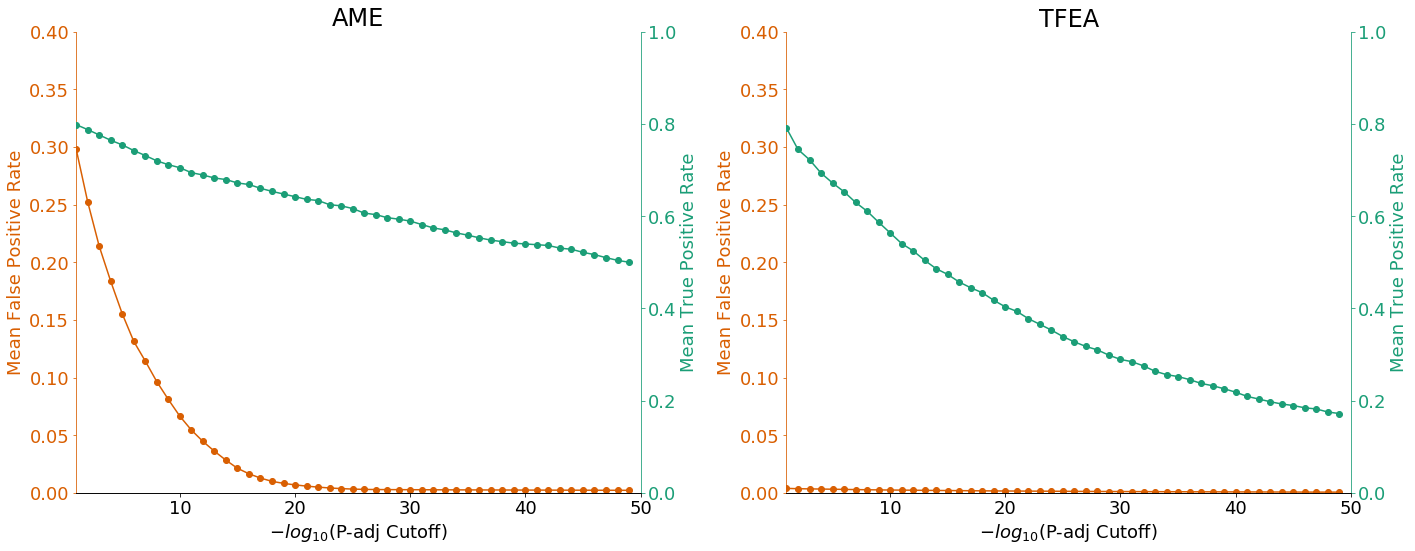

/Users/joru1876/TFEA_Jupyter/20190808_Benchmarking/Figures/pval_optimization_MeanFPRTPR.pdf

In [47]:
def parse_vbg_results(folder, pattern='*', ame=False):
    results = {}
    folder = Path(folder)
    exclude = [20,40,60,80]
    for file in folder.glob(pattern):
        key = int(file.stem.split('_')[1])
        b = int(file.stem.split('_')[2])
        i = int(file.stem.split('_')[3])
        if key not in exclude:
            if key not in results:
                results[key] = {}
            if b not in results[key]:
                results[key][b] = {}
            results[key][b][i] = []
            with open(file) as F:
                F.readline()
                for line in F:
                    linelist = line.strip().split('\t')
                    if ame:
                        try:
                            results[key][b][i].append([linelist[2]] + linelist[5:])
                        except:
                            pass
                    else:
                        results[key][b][i].append([linelist[0]] + [float(x) for x in linelist[1:]])
            results[key][b][i] = sorted(results[key][b][i])
    return results

def plot_heatmap(results, ax=None, motifs=None, e_index=None, p_index=None, p_cut=None, ame=False, 
                 metric='TPR', cmap=plt.cm.viridis, vmin=0, vmax=1):
    keys = sorted(list(results.keys()))
    data = [[0 for x in range(len(results))] for y in range(len(results[keys[0]]))]
    for x in range(len(keys)):
        key = keys[x]
        b_keys = sorted(list(results[key].keys()))
        for y in range(len(b_keys)):
            b = b_keys[y]
            TP = 0.0
            FP = 0.0
            TN = 0.0
            FN = 0.0
            f1 = 0
            TPR = 0
            FPR = 0
            for i in results[key][b]:
                for r in results[key][b][i]:
                    enrichment_list = []
                    if r[0] in motifs:
                        if ame:
                            enrichment = -1*float(r[e_index].split('e')[-1])
                            p_adj = float(r[p_index])
                        else:
                            enrichment = float(r[e_index])
                            p_adj = float(r[p_index])
                        if p_adj < p_cut:
                            TP += 1.0
                        else:
                            FN += 1.0
                        enrichment_list.append(enrichment)
                    else:
                        if ame:
                            enrichment = -1*float(r[e_index].split('e')[-1])
                            p_adj = float(r[p_index])
                        else:
                            enrichment = float(r[e_index])
                            p_adj = float(r[p_index])
                        if p_adj < p_cut:
                            FP += 1.0
                        else:
                            TN += 1.0
            try:
                precision = TP/(TP+FP)
                recall = TP/(TP+FN)
                f1 = 2*((precision*recall)/(precision+recall))
                TPR = TP/(TP+FN)
                FPR = FP/(FP+TN)
            except:
                pass
            if metric == 'f1':
                data[y][x] = f1
            elif metric == 'TPR':
                data[y][x] = TPR
            elif metric == 'FPR':
                data[y][x] = FPR

#     colors = Normalize(vmin, vmax, clip=True)(data)
#     colors = cmap(colors)
#     heatmap = ax.imshow(colors, aspect='auto')
#     ax.set_ylim([-0.5,10.5])
#     ax.set_ylabel("Background (%)")
#     ax.set_xlabel("Signal (%)")
#     xvals = [str(i) for i in range(0,1100,100)]
#     ax.set_xticks([i for i in range(len(data[0]))])
# #     ax.set_xticklabels(xvals, rotation=90)
#     ax.set_xticklabels([str(int(int(x)/10000*100)) for x in xvals])
#     ax.set_yticks([i for i in range(len(data))])
#     ax.set_yticklabels([str(i*10) for i in range(len(data))])
#     for spine in ax.spines:
#         ax.spines[spine].set_visible(False)
    
    
    return data

#=============================================================================================

results_folder = '/Users/joru1876/TFEA_Jupyter/20190808_Benchmarking/Titration_HCT116DMSO_core_VBG_10000_uniformbg/'
figuredir = './20190808_Benchmarking/Figures/'
pval_ranges = list(range(1,50))
motifs = ['P53_HUMAN.H11MO.0.A']#, 'P73_HUMAN.H11MO.0.A', 'P63_HUMAN.H11MO.0.A']


TFEA_results = parse_vbg_results(results_folder, pattern='*TFEA.txt', ame=False)
AME_results = parse_vbg_results(results_folder, pattern='*AME.txt', ame=True)
TFEA_scatter_y = []
AME_scatter_y = []
for p in pval_ranges:
    TFEA_data = plot_heatmap(TFEA_results, motifs=motifs, e_index=1, p_index=-2, p_cut=float(f'1e-{p}'), metric='FPR')
    TFEA_f1_sum = np.matrix(TFEA_data).mean()
    TFEA_scatter_y.append(TFEA_f1_sum)
    AME_data = plot_heatmap(AME_results, motifs=motifs, e_index=1, p_index=2, p_cut=float(f'1e-{p}'), metric='FPR')
    AME_f1_sum = np.matrix(AME_data).mean()
    AME_scatter_y.append(AME_f1_sum)
    
TFEA_TPR = []
AME_TPR = []
for p in pval_ranges:
    TFEA_data = plot_heatmap(TFEA_results, motifs=motifs, e_index=1, p_index=-2, p_cut=float(f'1e-{p}'), metric='TPR')
    TFEA_f1_sum = np.matrix(TFEA_data).mean()
    TFEA_TPR.append(TFEA_f1_sum)
    AME_data = plot_heatmap(AME_results, motifs=motifs, e_index=1, p_index=2, p_cut=float(f'1e-{p}'), metric='TPR')
    AME_f1_sum = np.matrix(AME_data).mean()
    AME_TPR.append(AME_f1_sum)
    
F = plt.figure(figsize=(20,8))
ax = F.add_subplot(122)
axis_color = '#d95f02'
ax.set_title("TFEA", fontsize=24, pad=-100)
ax.scatter(pval_ranges, TFEA_scatter_y, c=axis_color)
ax.plot(pval_ranges, TFEA_scatter_y, c=axis_color)
ax.set_ylabel("Mean False Positive Rate", color=axis_color)
ax.set_xlabel("$-log_{10}$(P-adj Cutoff)")
ax.set_xlim([1,50])
ax.set_ylim([0,0.4])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_edgecolor(axis_color)
ax.tick_params(axis='y', color=axis_color, labelcolor=axis_color)

axR = ax.twinx()
axis_color = '#1b9e77'
axR.scatter(pval_ranges, TFEA_TPR, c=axis_color)
axR.plot(pval_ranges, TFEA_TPR, c=axis_color)
axR.spines['top'].set_visible(False)
axR.spines['left'].set_visible(False)
axR.spines['right'].set_edgecolor(axis_color)
axR.tick_params(axis='y', color=axis_color, labelcolor=axis_color)
axR.set_ylabel("Mean True Positive Rate", color=axis_color)
axR.set_ylim([0,1])


ax2 = F.add_subplot(121)
ax2.set_title("AME", fontsize=24)
axis_color = '#d95f02'
ax2.plot(pval_ranges, AME_scatter_y, c=axis_color)
ax2.scatter(pval_ranges, AME_scatter_y, c=axis_color)
ax2.set_ylabel("Mean False Positive Rate", color=axis_color)
ax2.set_xlabel("$-log_{10}$(P-adj Cutoff)")
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_edgecolor(axis_color)
ax2.tick_params(axis='y', color=axis_color, labelcolor=axis_color)
ax2.plot([AME_scatter_y.index(max(AME_scatter_y)),AME_scatter_y.index(max(AME_scatter_y))],
         [0,max(AME_scatter_y)], linestyle='--', alpha=0.5, c='k')
ax2.plot([0,AME_scatter_y.index(max(AME_scatter_y))],
         [max(AME_scatter_y),max(AME_scatter_y)], linestyle='--', alpha=0.5, c='k')
ax2.set_ylim([0,0.4])
ax2.set_xlim([1,50])

axR = ax2.twinx()
axis_color = '#1b9e77'
axR.scatter(pval_ranges, AME_TPR, c=axis_color)
axR.plot(pval_ranges, AME_TPR, c=axis_color)
axR.spines['top'].set_visible(False)
axR.spines['left'].set_visible(False)
axR.spines['right'].set_edgecolor(axis_color)
axR.tick_params(axis='y', color=axis_color, labelcolor=axis_color)
axR.set_ylabel("Mean True Positive Rate", color=axis_color)
axR.set_ylim([0,1])

# print(AME_scatter_y.index(max(AME_scatter_y)), TFEA_scatter_y.index(max(TFEA_scatter_y)))
# print(AME_scatter_y)

plt.tight_layout()
figname=figuredir + 'pval_optimization_MeanFPRTPR.pdf'
F.savefig(figname, format="pdf")
plt.show()
FileLink(figname)


## Signal to Noise F1-Score Calculation

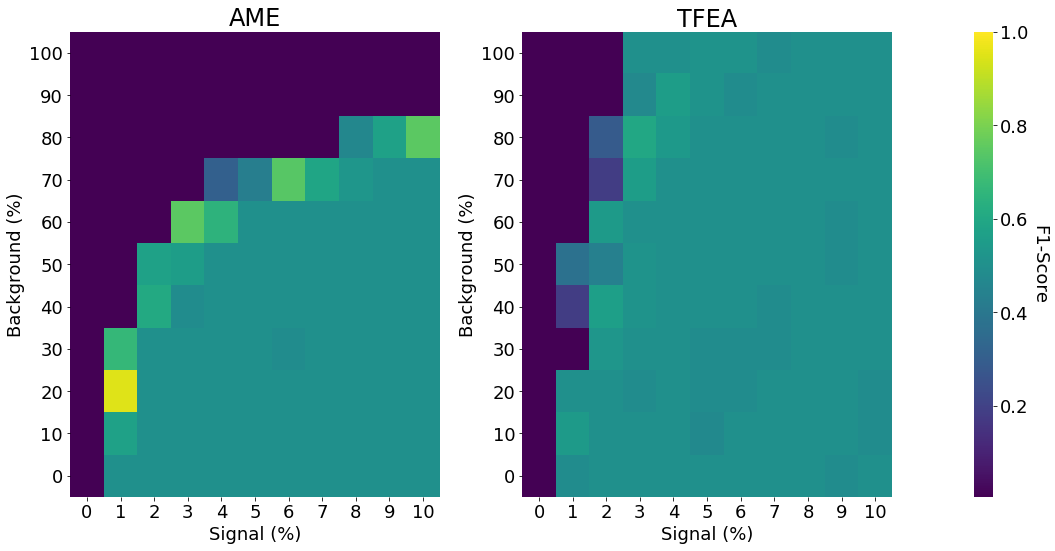

/Users/joru1876/TFEA_Jupyter/20190808_Benchmarking/Figures/TitrationVBG_core_s15000_heatmaps_10000_uniformbg.pdf

In [51]:
def parse_vbg_results(folder, pattern='*', ame=False):
    results = {}
    folder = Path(folder)
    exclude = [20,40,60,80]
    for file in folder.glob(pattern):
        key = int(file.stem.split('_')[1])
        b = int(file.stem.split('_')[2])
        i = int(file.stem.split('_')[3])
        if key not in exclude:
            if key not in results:
                results[key] = {}
            if b not in results[key]:
                results[key][b] = {}
            results[key][b][i] = []
            with open(file) as F:
                F.readline()
                for line in F:
                    linelist = line.strip().split('\t')
                    if ame:
                        try:
                            results[key][b][i].append([linelist[2]] + linelist[5:])
                        except:
                            pass
                    else:
                        results[key][b][i].append([linelist[0]] + [float(x) for x in linelist[1:]])
            results[key][b][i] = sorted(results[key][b][i])
    return results

def plot_heatmap(results, ax=None, motif=None, e_index=None, p_index=None, p_cut=None, ame=False, 
                 metric='TPR', cmap=plt.cm.viridis, vmin=0, vmax=1):
    keys = sorted(list(results.keys()))
    data = [[0 for x in range(len(results))] for y in range(len(results[keys[0]]))]
    for x in range(len(keys)):
        key = keys[x]
        b_keys = sorted(list(results[key].keys()))
        for y in range(len(b_keys)):
            b = b_keys[y]
            TP = 0.0
            FP = 0.0
            TN = 0.0
            FN = 0.0
            f1 = 0
            TPR = 0
            FPR = 0
            for i in results[key][b]:
                for r in results[key][b][i]:
                    enrichment_list = []
                    if r[0] == motif:
                        if ame:
                            enrichment = -1*float(r[e_index].split('e')[-1])
                            p_adj = float(r[p_index])
                        else:
                            enrichment = float(r[e_index])
                            p_adj = float(r[p_index])
                        if p_adj < p_cut:
                            TP += 1.0
                        else:
                            FN += 1.0
                        enrichment_list.append(enrichment)
                    else:
                        if ame:
                            enrichment = -1*float(r[e_index].split('e')[-1])
                            p_adj = float(r[p_index])
                        else:
                            enrichment = float(r[e_index])
                            p_adj = float(r[p_index])
                        if p_adj < p_cut:
                            FP += 1.0
                        else:
                            TN += 1.0
            try:
                precision = TP/(TP+FP)
                recall = TP/(TP+FN)
                f1 = 2*((precision*recall)/(precision+recall))
                TPR = TP/(TP+FN)
                FPR = FP/(FP+TN)
            except:
                pass
            if metric == 'f1':
                data[y][x] = f1
            elif metric == 'TPR':
                data[y][x] = TPR
            elif metric == 'FPR':
                data[y][x] = FPR

    colors = Normalize(vmin, vmax, clip=True)(data)
    colors = cmap(colors)
    heatmap = ax.imshow(colors, aspect='auto')
    ax.set_ylim([-0.5,10.5])
    ax.set_ylabel("Background (%)")
    ax.set_xlabel("Signal (%)")
    xvals = [str(i) for i in range(0,1100,100)]
    ax.set_xticks([i for i in range(len(data[0]))])
#     ax.set_xticklabels(xvals, rotation=90)
    ax.set_xticklabels([str(int(int(x)/10000*100)) for x in xvals])
    ax.set_yticks([i for i in range(len(data))])
    ax.set_yticklabels([str(i*10) for i in range(len(data))])
    for spine in ax.spines:
        ax.spines[spine].set_visible(False)
    
    
    return heatmap, data

#=============================================================================================

results_folder = '/Users/joru1876/TFEA_Jupyter/20190808_Benchmarking/Titration_HCT116DMSO_core_VBG_10000_uniformbg/'
figuredir = './20190808_Benchmarking/Figures/'
p_cut = 1e-1

F = plt.figure(figsize=(15,8))
gs = gridspec.GridSpec(1, 3, width_ratios=[20,20,1])
ax = F.add_subplot(gs[1])
ax.set_title("TFEA", fontsize=24, pad=-100)
results = parse_vbg_results(results_folder, pattern='*TFEA.txt', ame=False)
_, TFEA_data = plot_heatmap(results, ax=ax, motif='P53_HUMAN.H11MO.0.A', e_index=1, p_index=-2, p_cut=1e-1, metric='f1')

ax2 = F.add_subplot(gs[0])
ax2.set_title("AME", fontsize=24)
results = parse_vbg_results(results_folder, pattern='*AME.txt', ame=True)
heatmap, AME_data = plot_heatmap(results, ax=ax2, motif='P53_HUMAN.H11MO.0.A', e_index=1, p_index=2, p_cut=1e-30, metric='f1')


cbar_ax = F.add_subplot(gs[2])
cbar = plt.colorbar(heatmap, cax=cbar_ax)
cbar.set_label('F1-Score', rotation=270, labelpad=20)
cbar.outline.set_visible(False)


gs.tight_layout(F)
figname=figuredir + f'TitrationVBG_core_s15000_heatmaps_10000_uniformbg.pdf'
F.savefig(figname, format="pdf")
plt.show()
FileLink(figname)


## Variance to Noise F1-Score Calculation

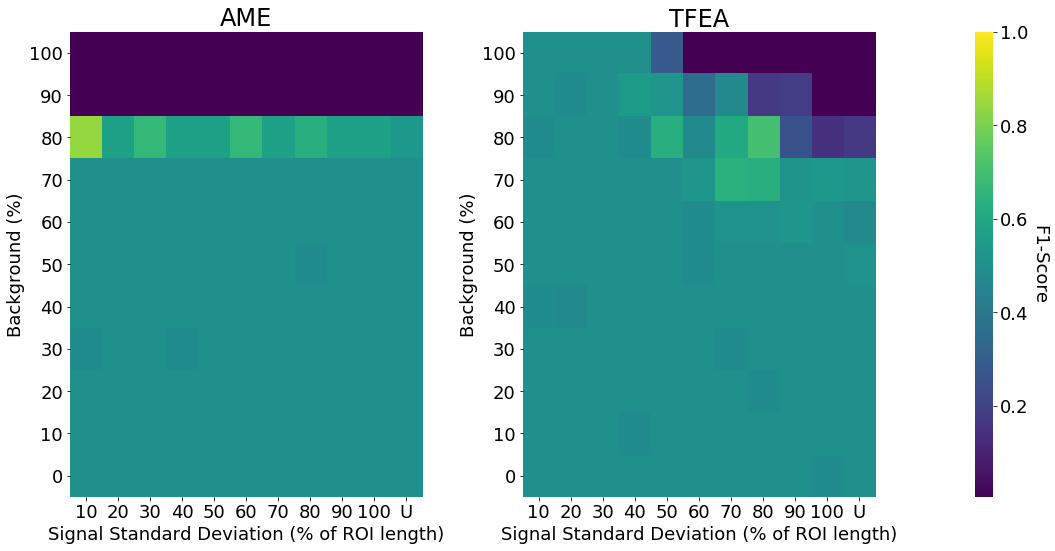

/Users/joru1876/TFEA_Jupyter/20190808_Benchmarking/Figures/Variance_core_s15000_heatmaps_10000_uniformbg.pdf

In [42]:
def parse_vbg_results(folder, pattern='*', ame=False):
    results = {}
    folder = Path(folder)
    exclude = [20,40,60,80]
    for file in folder.glob(pattern):
        key = file.stem.split('_')[1]
        key = int(key) if key != 'u' else key
        b = int(file.stem.split('_')[2])
        i = int(file.stem.split('_')[3])
        if key not in exclude:
            if key not in results:
                results[key] = {}
            if b not in results[key]:
                results[key][b] = {}
            results[key][b][i] = []
            with open(file) as F:
                F.readline()
                for line in F:
                    linelist = line.strip().split('\t')
                    if ame:
                        try:
                            results[key][b][i].append([linelist[2]] + linelist[5:])
                        except:
                            pass
                    else:
                        results[key][b][i].append([linelist[0]] + [float(x) for x in linelist[1:]])
            results[key][b][i] = sorted(results[key][b][i])
    return results

def plot_heatmap(results, ax=None, motif=None, e_index=None, p_index=None, p_cut=None, ame=False, 
                 metric='TPR', cmap=plt.cm.viridis, vmin=0, vmax=1):
    keys = sorted([k for k in list(results.keys()) if type(k) == int])
    keys = keys + [k for k in list(results.keys()) if type(k) != int]
    data = [[0 for x in range(len(results))] for y in range(len(results[keys[0]]))]
    for x in range(len(keys)):
        key = keys[x]
        b_keys = sorted(list(results[key].keys()))
        for y in range(len(b_keys)):
            b = b_keys[y]
            TP = 0.0
            FP = 0.0
            TN = 0.0
            FN = 0.0
            f1 = 0
            TPR = 0
            FPR = 0
            for i in results[key][b]:
                for r in results[key][b][i]:
                    enrichment_list = []
                    if r[0] == motif:
                        if ame:
                            enrichment = -1*float(r[e_index].split('e')[-1])
                            p_adj = float(r[p_index])
                        else:
                            enrichment = float(r[e_index])
                            p_adj = float(r[p_index])
                        if p_adj < p_cut:
                            TP += 1.0
                        else:
                            FN += 1.0
                        enrichment_list.append(enrichment)
                    else:
                        if ame:
                            enrichment = -1*float(r[e_index].split('e')[-1])
                            p_adj = float(r[p_index])
                        else:
                            enrichment = float(r[e_index])
                            p_adj = float(r[p_index])
                        if p_adj < p_cut:
                            FP += 1.0
                        else:
                            TN += 1.0
            try:
                precision = TP/(TP+FP)
                recall = TP/(TP+FN)
                f1 = 2*((precision*recall)/(precision+recall))
                TPR = TP/(TP+FN)
                FPR = FP/(FP+TN)
            except:
                pass
            if metric == 'f1':
                data[y][x] = f1
            elif metric == 'TPR':
                data[y][x] = TPR
            elif metric == 'FPR':
                data[y][x] = FPR

    colors = Normalize(vmin, vmax, clip=True)(data)
    colors = cmap(colors)
    heatmap = ax.imshow(colors, aspect='auto')
    ax.set_ylim([-0.5,10.5])
    ax.set_ylabel("Background (%)")
    ax.set_xlabel("Signal Standard Deviation (% of ROI length)")
    xvals = [str(i) for i in range(0,1200,100)]
    ax.set_xticks([i for i in range(len(data[0]))])
#     ax.set_xticklabels(xvals, rotation=90)
    ax.set_xticklabels([str(int(int(x)/10000*1000)+10) for x in xvals[:-2]] + ['U'])
    ax.set_yticks([i for i in range(len(data))])
    ax.set_yticklabels([str(i*10) for i in range(len(data))])
    for spine in ax.spines:
        ax.spines[spine].set_visible(False)
    
    
    return heatmap, data

#=============================================================================================

results_folder = '/Users/joru1876/TFEA_Jupyter/20190808_Benchmarking/Variance_HCT116DMSO_core_VBG_uniformbg/'
figuredir = './20190808_Benchmarking/Figures/'

F = plt.figure(figsize=(15,8))
gs = gridspec.GridSpec(1, 3, width_ratios=[20,20,1])
ax = F.add_subplot(gs[1])
ax.set_title("TFEA", fontsize=24, pad=-100)
results = parse_vbg_results(results_folder, pattern='*TFEA.txt', ame=False)
_, TFEA_data = plot_heatmap(results, ax=ax, motif='P53_HUMAN.H11MO.0.A', e_index=1, p_index=-2, p_cut=1e-1, metric='f1')

ax2 = F.add_subplot(gs[0])
ax2.set_title("AME", fontsize=24)
results = parse_vbg_results(results_folder, pattern='*AME.txt', ame=True)
heatmap, AME_data = plot_heatmap(results, ax=ax2, motif='P53_HUMAN.H11MO.0.A', e_index=1, p_index=2, p_cut=1e-30, metric='f1')


cbar_ax = F.add_subplot(gs[2])
cbar = plt.colorbar(heatmap, cax=cbar_ax)
cbar.set_label('F1-Score', rotation=270, labelpad=20)
cbar.outline.set_visible(False)


gs.tight_layout(F)
figname=figuredir + 'Variance_core_s15000_heatmaps_10000_uniformbg.pdf'
F.savefig(figname, format="pdf")
plt.show()
FileLink(figname)


# Supplemental Figures

## Signal to Noise F1-Score Difference

TFEA:  32 AME:  26


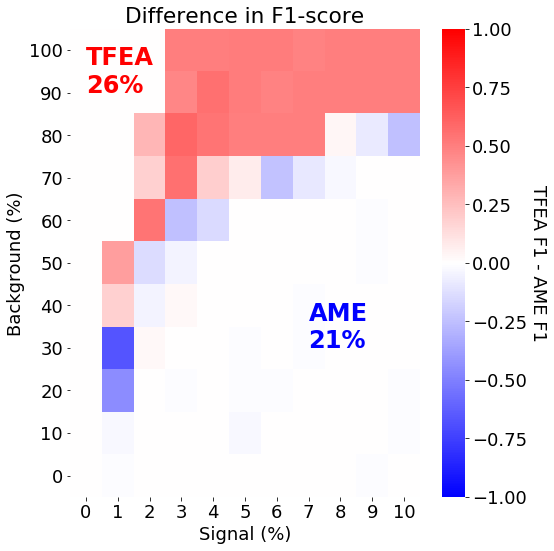

/Users/joru1876/TFEA_Jupyter/20190808_Benchmarking/Figures/TitrationVBG_core_s15000_differential_10000_uniformbg.pdf

In [45]:
def parse_vbg_results(folder, pattern='*', ame=False):
    results = {}
    folder = Path(folder)
    exclude = [20,40,60,80]
    for file in folder.glob(pattern):
        key = int(file.stem.split('_')[1])
        b = int(file.stem.split('_')[2])
        i = int(file.stem.split('_')[3])
        if key not in exclude:
            if key not in results:
                results[key] = {}
            if b not in results[key]:
                results[key][b] = {}
            results[key][b][i] = []
            with open(file) as F:
                F.readline()
                for line in F:
                    linelist = line.strip().split('\t')
                    if ame:
                        try:
                            results[key][b][i].append([linelist[2]] + linelist[5:])
                        except:
                            pass
                    else:
                        results[key][b][i].append([linelist[0]] + [float(x) for x in linelist[1:]])
            results[key][b][i] = sorted(results[key][b][i])
    return results

def plot_differential_heatmap(TFEA_results, AME_results, ax=None, motif=None, te_index=None, ae_index=None, 
                              tp_index=None, ap_index=None,
                              tp_cut=None, ap_cut=None, metric='f1', cmap=plt.cm.bwr, vmin=-1, vmax=1):
    keys = sorted(list(TFEA_results.keys()))
    AME_data = [[0 for x in range(len(AME_results))] for y in range(len(AME_results[keys[0]]))]
    for x in range(len(keys)):
        key = keys[x]
        b_keys = sorted(list(AME_results[key].keys()))
        for y in range(len(b_keys)):
            b = b_keys[y]
            TP = 0.0
            FP = 0.0
            TN = 0.0
            FN = 0.0
            f1 = 0
            TPR = 0
            FPR = 0
            for i in AME_results[key][b]:
                for r in AME_results[key][b][i]:
                    enrichment_list = []
                    if r[0] == motif:
                        enrichment = -1*float(r[ae_index].split('e')[-1])
                        p_adj = float(r[ap_index])
                        if p_adj < ap_cut:
                            TP += 1.0
                        else:
                            FN += 1.0
                        enrichment_list.append(enrichment)
                    else:
                        enrichment = float(r[ae_index])
                        p_adj = float(r[ap_index])
                        if p_adj < ap_cut:
                            FP += 1.0
                        else:
                            TN += 1.0
            try:
                precision = TP/(TP+FP)
                recall = TP/(TP+FN)
                f1 = 2*((precision*recall)/(precision+recall))
                TPR = TP/(TP+FN)
                FPR = FP/(FP+TN)
            except:
                pass
            if metric == 'f1':
                AME_data[y][x] = f1
            elif metric == 'TPR':
                AME_data[y][x] = TPR
            elif metric == 'FPR':
                AME_data[y][x] = FPR
    
    TFEA_data = [[0 for x in range(len(TFEA_results))] for y in range(len(TFEA_results[keys[0]]))]
    for x in range(len(keys)):
        key = keys[x]
        b_keys = sorted(list(TFEA_results[key].keys()))
        for y in range(len(b_keys)):
            b = b_keys[y]
            TP = 0.0
            FP = 0.0
            TN = 0.0
            FN = 0.0
            f1 = 0
            TPR = 0
            FPR = 0
            for i in TFEA_results[key][b]:
                for r in TFEA_results[key][b][i]:
                    enrichment_list = []
                    if r[0] == motif:
                        enrichment = float(r[te_index])
                        p_adj = float(r[tp_index])
                        if p_adj < tp_cut:
                            TP += 1.0
                        else:
                            FN += 1.0
                        enrichment_list.append(enrichment)
                    else:
                        enrichment = float(r[te_index])
                        p_adj = float(r[tp_index])
                        if p_adj < tp_cut:
                            FP += 1.0
                        else:
                            TN += 1.0
            try:
                precision = TP/(TP+FP)
                recall = TP/(TP+FN)
                f1 = 2*((precision*recall)/(precision+recall))
                TPR = TP/(TP+FN)
                FPR = FP/(FP+TN)
            except:
                pass
            if metric == 'f1':
                TFEA_data[y][x] = f1
            elif metric == 'TPR':
                TFEA_data[y][x] = TPR
            elif metric == 'FPR':
                TFEA_data[y][x] = FPR
    
    matrix_data = np.subtract(np.array(TFEA_data), np.array(AME_data))
    total_squares = matrix_data.shape[0]*matrix_data.shape[1]
    print("TFEA: ", len(np.where(matrix_data > 0)[0]), "AME: ", len(np.where(matrix_data < 0)[0]))
    TFEA_percentage_of_squares = 100*len(np.where(matrix_data > 0)[0])/total_squares
    AME_percentage_of_squares = 100*len(np.where(matrix_data < 0)[0])/total_squares
    ax.text(0,9, 'TFEA\n' + str("%.2g" % TFEA_percentage_of_squares) + '%', fontweight='bold', c='r', fontsize=24)
    ax.text(7,3, 'AME\n' + str("%.2g" % AME_percentage_of_squares) + '%', fontweight='bold', c='b', fontsize=24)
    colors = Normalize(-1, 1, clip=True)(matrix_data)
    colors = cmap(colors)
    heatmap = ax.imshow(colors, aspect='auto')
    ax.set_ylim([-0.5,10.5])
    norm = Normalize(vmin=-1,vmax=1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = plt.colorbar(sm)
    cbar.set_label('TFEA F1 - AME F1', rotation=270, labelpad=20)
    cbar.outline.set_visible(False)
    ax.set_ylim([-0.5,10.5])
    ax.set_title("Difference in F1-score")
    ax.set_ylabel("Background (%)")
    ax.set_xlabel("Signal (%)")
    xvals = [str(i) for i in range(0,1100,100)]
    ax.set_xticks([i for i in range(len(TFEA_data[0]))])
#     ax.set_xticklabels(xvals, rotation=90)
    ax.set_xticklabels([str(int(int(x)/10000*100)) for x in xvals])
    ax.set_yticks([i for i in range(len(TFEA_data))])
    ax.set_yticklabels([str(i*10) for i in range(len(TFEA_data))])
    for spine in ax.spines:
        ax.spines[spine].set_visible(False)

#=============================================================================================

results_folder = '/Users/joru1876/TFEA_Jupyter/20190808_Benchmarking/Titration_HCT116DMSO_core_VBG_10000_uniformbg/'
figuredir = './20190808_Benchmarking/Figures/'


F = plt.figure(figsize=(8,8))
ax = F.add_subplot(111)
TFEA_results = parse_vbg_results(results_folder, pattern='*TFEA.txt', ame=False)
AME_results = parse_vbg_results(results_folder, pattern='*AME.txt', ame=True)
plot_differential_heatmap(TFEA_results, AME_results, ax=ax, motif='P53_HUMAN.H11MO.0.A', 
                          te_index=1, ae_index=1, 
                          tp_index=-2, ap_index=2,
                          tp_cut=1e-1, ap_cut=1e-30, 
                          metric='f1', cmap=plt.cm.bwr, 
                          vmin=-1, vmax=1)

plt.tight_layout()
figname=figuredir + 'TitrationVBG_core_s15000_differential_10000_uniformbg.pdf'
F.savefig(figname, format="pdf")
plt.show()
FileLink(figname)


## Variance to Noise F1-Score Difference

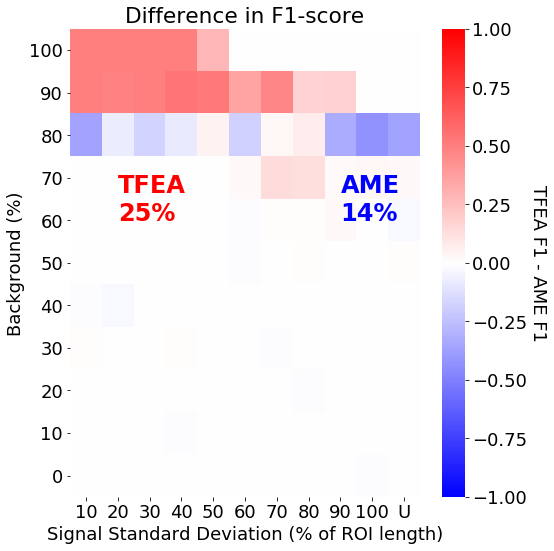

/Users/joru1876/TFEA_Jupyter/20190808_Benchmarking/Figures/VarianceVBG_core_s15000_differential_10000_uniformbg.pdf

In [50]:
def parse_vbg_results(folder, pattern='*', ame=False):
    results = {}
    folder = Path(folder)
    exclude = [20,40,60,80]
    for file in folder.glob(pattern):
        key = file.stem.split('_')[1]
        key = int(key) if key != 'u' else key
        b = int(file.stem.split('_')[2])
        i = int(file.stem.split('_')[3])
        if key not in exclude:
            if key not in results:
                results[key] = {}
            if b not in results[key]:
                results[key][b] = {}
            results[key][b][i] = []
            with open(file) as F:
                F.readline()
                for line in F:
                    linelist = line.strip().split('\t')
                    if ame:
                        try:
                            results[key][b][i].append([linelist[2]] + linelist[5:])
                        except:
                            pass
                    else:
                        results[key][b][i].append([linelist[0]] + [float(x) for x in linelist[1:]])
            results[key][b][i] = sorted(results[key][b][i])
    return results

def plot_differential_heatmap(TFEA_results, AME_results, ax=None, motif=None, te_index=None, ae_index=None, 
                              tp_index=None, ap_index=None,
                              tp_cut=None, ap_cut=None, metric='f1', cmap=plt.cm.bwr, vmin=-1, vmax=1):
    keys = sorted([k for k in list(TFEA_results.keys()) if type(k) == int])
    keys = keys + [k for k in list(TFEA_results.keys()) if type(k) != int]
    AME_data = [[0 for x in range(len(AME_results))] for y in range(len(AME_results[keys[0]]))]
    for x in range(len(keys)):
        key = keys[x]
        b_keys = sorted(list(AME_results[key].keys()))
        for y in range(len(b_keys)):
            b = b_keys[y]
            TP = 0.0
            FP = 0.0
            TN = 0.0
            FN = 0.0
            f1 = 0
            TPR = 0
            FPR = 0
            for i in AME_results[key][b]:
                for r in AME_results[key][b][i]:
                    enrichment_list = []
                    if r[0] == motif:
                        enrichment = -1*float(r[ae_index].split('e')[-1])
                        p_adj = float(r[ap_index])
                        if p_adj < ap_cut:
                            TP += 1.0
                        else:
                            FN += 1.0
                        enrichment_list.append(enrichment)
                    else:
                        enrichment = float(r[ae_index])
                        p_adj = float(r[ap_index])
                        if p_adj < ap_cut:
                            FP += 1.0
                        else:
                            TN += 1.0
            try:
                precision = TP/(TP+FP)
                recall = TP/(TP+FN)
                f1 = 2*((precision*recall)/(precision+recall))
                TPR = TP/(TP+FN)
                FPR = FP/(FP+TN)
            except:
                pass
            if metric == 'f1':
                AME_data[y][x] = f1
            elif metric == 'TPR':
                AME_data[y][x] = TPR
            elif metric == 'FPR':
                AME_data[y][x] = FPR
    
    TFEA_data = [[0 for x in range(len(TFEA_results))] for y in range(len(TFEA_results[keys[0]]))]
    for x in range(len(keys)):
        key = keys[x]
        b_keys = sorted(list(TFEA_results[key].keys()))
        for y in range(len(b_keys)):
            b = b_keys[y]
            TP = 0.0
            FP = 0.0
            TN = 0.0
            FN = 0.0
            f1 = 0
            TPR = 0
            FPR = 0
            for i in TFEA_results[key][b]:
                for r in TFEA_results[key][b][i]:
                    enrichment_list = []
                    if r[0] == motif:
                        enrichment = float(r[te_index])
                        p_adj = float(r[tp_index])
                        if p_adj < tp_cut:
                            TP += 1.0
                        else:
                            FN += 1.0
                        enrichment_list.append(enrichment)
                    else:
                        enrichment = float(r[te_index])
                        p_adj = float(r[tp_index])
                        if p_adj < tp_cut:
                            FP += 1.0
                        else:
                            TN += 1.0
            try:
                precision = TP/(TP+FP)
                recall = TP/(TP+FN)
                f1 = 2*((precision*recall)/(precision+recall))
                TPR = TP/(TP+FN)
                FPR = FP/(FP+TN)
            except:
                pass
            if metric == 'f1':
                TFEA_data[y][x] = f1
            elif metric == 'TPR':
                TFEA_data[y][x] = TPR
            elif metric == 'FPR':
                TFEA_data[y][x] = FPR
    
    matrix_data = np.subtract(np.array(TFEA_data), np.array(AME_data))
    total_squares = matrix_data.shape[0]*matrix_data.shape[1]
    TFEA_percentage_of_squares = 100*len(np.where(matrix_data > 0)[0])/total_squares
    AME_percentage_of_squares = 100*len(np.where(matrix_data < 0)[0])/total_squares
    ax.text(1,6, 'TFEA\n' + str(round(TFEA_percentage_of_squares)) + '%', fontweight='bold', c='r', fontsize=24)
    ax.text(8,6, 'AME\n' + str(round(AME_percentage_of_squares)) + '%', fontweight='bold', c='b', fontsize=24)
    colors = Normalize(-1, 1, clip=True)(matrix_data)
    colors = cmap(colors)
    heatmap = ax.imshow(colors, aspect='auto')
    ax.set_ylim([-0.5,10.5])
    norm = Normalize(vmin=-1,vmax=1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = plt.colorbar(sm)
    cbar.set_label('TFEA F1 - AME F1', rotation=270, labelpad=20)
    cbar.outline.set_visible(False)
    ax.set_ylim([-0.5,10.5])
    ax.set_title("Difference in F1-score")
    ax.set_ylabel("Background (%)")
    ax.set_xlabel("Signal Standard Deviation (% of ROI length)")
    xvals = [str(i) for i in range(0,1200,100)]
    ax.set_xticks([i for i in range(len(TFEA_data[0]))])
#     ax.set_xticklabels(xvals, rotation=90)
    ax.set_xticklabels([str(int(int(x)/10000*1000)+10) for x in xvals[:-2]] + ['U'])
    ax.set_yticks([i for i in range(len(TFEA_data))])
    ax.set_yticklabels([str(i*10) for i in range(len(TFEA_data))])
    for spine in ax.spines:
        ax.spines[spine].set_visible(False)

#=============================================================================================

results_folder = '/Users/joru1876/TFEA_Jupyter/20190808_Benchmarking/Variance_HCT116DMSO_core_VBG_uniformbg/'
figuredir = './20190808_Benchmarking/Figures/'


F = plt.figure(figsize=(8,8))
ax = F.add_subplot(111)
TFEA_results = parse_vbg_results(results_folder, pattern='*TFEA.txt', ame=False)
AME_results = parse_vbg_results(results_folder, pattern='*AME.txt', ame=True)
plot_differential_heatmap(TFEA_results, AME_results, ax=ax, motif='P53_HUMAN.H11MO.0.A', 
                          te_index=1, ae_index=1, 
                          tp_index=-2, ap_index=2,
                          tp_cut=1e-1, ap_cut=1e-30, 
                          metric='f1', cmap=plt.cm.bwr, 
                          vmin=-1, vmax=1)

plt.tight_layout()
figname=figuredir + 'VarianceVBG_core_s15000_differential_10000_uniformbg.pdf'
F.savefig(figname, format="pdf")
plt.show()
FileLink(figname)


## Runtime and Memory Usage Comparison

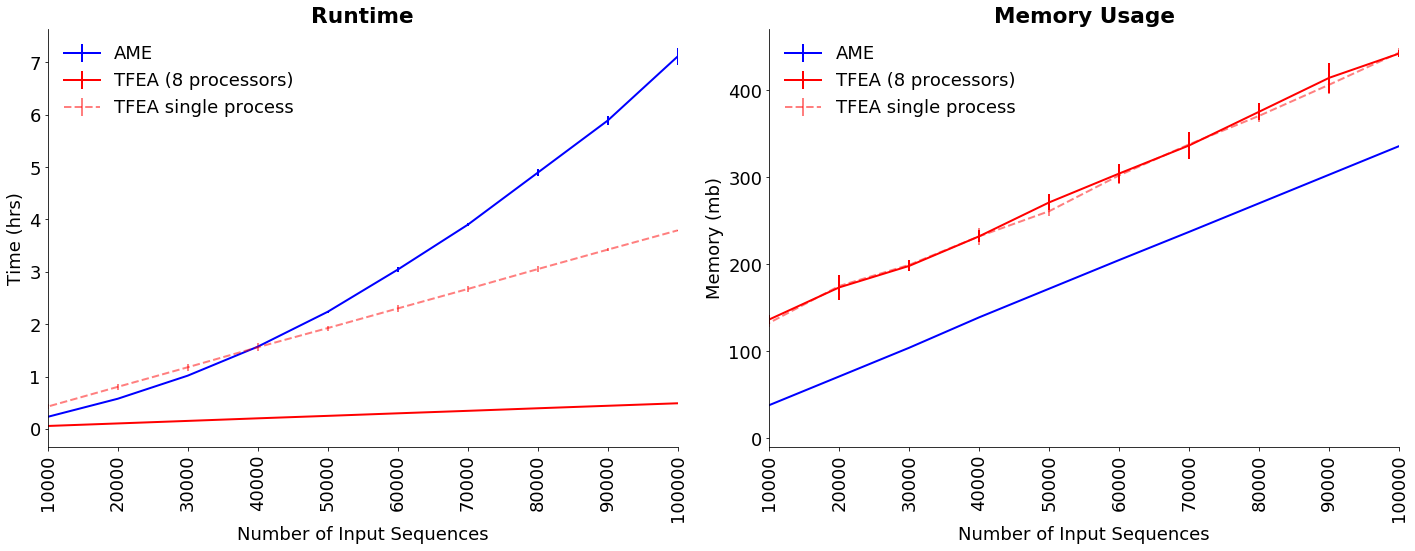

/Users/joru1876/TFEA_Jupyter/20190808_Benchmarking/Figures/TimeandMemory.pdf

In [3]:
def format_violin(violinobj, color=None, alpha=1):
    for pc in violinobj['bodies']:
        pc.set_facecolor(color)
        pc.set_alpha(alpha) 

def parse_time_results(results_folder, pattern='*'):
    results = {}
    folder = Path(results_folder)
    counter = -100000
    for file in folder.glob(pattern):
        key = int(file.stem.split('_')[1])
        i = int(file.stem.split('_')[2])
        if key not in results:
            results[key] = {}
        results[key][i] = {}
        with open(file) as F:
            F.readline()
            for line in F:
                linelist = line.strip().split()
                if len(linelist) > 0 and 'TimeMemoryUsage' in linelist[0]:
                    counter = 0
                    assay = linelist[0].replace('TimeMemoryUsage:', '')
                    usertime = float(linelist[linelist.index('user')-1])/3600
                    systime = float(linelist[linelist.index('system')-1])/3600
                    realtime = linelist[linelist.index('real')-1].split(':')
                    if len(realtime) == 1:
                        realtime = float(realtime[0])/3600
                    elif len(realtime) == 2:
                        realtime = (float(realtime[0])*60 + float(realtime[1]))/3600
                    elif len(realtime) == 3:
                        realtime = ((float(realtime[0])*60 + float(realtime[1]))*60 + float(realtime[2]))/3600
                if counter == 4:
                    maxmemory = float(linelist[-2])/1024
                    results[key][i][assay] = [usertime, systime, realtime, maxmemory]
                counter += 1
            
    return results

def plot_time_results(time_results, ax=None, metric='Time', one_processor=False):
    xvals = sorted(time_results.keys())
    TFEA_results = []
    AME_results = []
    TFEA_process_results = []
    AME_process_results = []
    for key in xvals:
        TFEA_results.append([])
        AME_results.append([])
        TFEA_process_results.append([])
        AME_process_results.append([])
        for i in time_results[key]:
            if metric == 'Time':
                TFEA_results[-1].append(time_results[key][i]['TFEA'][2])
                AME_results[-1].append(time_results[key][i]['AME'][2])
                TFEA_process_results[-1].append(sum(time_results[key][i]['TFEA'][:1]))
                AME_process_results[-1].append(sum(time_results[key][i]['AME'][:1]))
            elif metric == 'Memory':
                TFEA_results[-1].append(time_results[key][i]['TFEA'][-1])
                AME_results[-1].append(time_results[key][i]['AME'][-1])
                TFEA_process_results[-1].append(time_results[key][i]['TFEA'][-1]/8.0)
                AME_process_results[-1].append(time_results[key][i]['AME'][-1])
    
    if one_processor != False:
        TFEA_process_results = []
        AME_process_results = []
        for key in xvals:
            TFEA_process_results.append([])
            AME_process_results.append([])
            for i in time_results[key]:
                if metric == 'Time':
                    TFEA_process_results[-1].append(sum(one_processor[key][i]['TFEA'][:1]))
                    AME_process_results[-1].append(sum(one_processor[key][i]['AME'][:1]))
                elif metric == 'Memory':
                    try:
                        TFEA_process_results[-1].append(one_processor[key][i]['TFEA'][-1])
                        AME_process_results[-1].append(one_processor[key][i]['AME'][-1])
                    except:
                        print(key,i)
                        pass
    
    
    ax.errorbar(xvals, [np.mean(y) for y in AME_results], yerr=[np.std(y) for y in AME_results],
                linewidth=2, color='blue', label='AME')
#     ax.errorbar(xvals, [np.mean(y) for y in AME_process_results], yerr=[np.std(y) for y in AME_process_results],
#                 linewidth=2, linestyle='--', color='blue', label='AME process')
    ax.errorbar(xvals, [np.mean(y) for y in TFEA_results], yerr=[np.std(y) for y in TFEA_results],
                linewidth=2, color='red', label='TFEA (8 processors)')
    ax.errorbar(xvals, [np.mean(y) for y in TFEA_process_results], yerr=[np.std(y) for y in TFEA_process_results],
                linewidth=2, linestyle='--', color='red', alpha=0.5, label='TFEA single process')
    
#     violin = ax.violinplot(AME_results, positions=[x-500 for x in xvals], widths=200, showmedians=True)
#     format_violin(violin, color='blue')
#     violin = ax.violinplot(AME_process_results, positions=[x-250 for x in xvals], widths=200, showmedians=True)
#     format_violin(violin, color='blue', alpha=0.5)
#     violin = ax.violinplot(TFEA_results, positions=[x+250 for x in xvals], widths=200, showmedians=True)
#     format_violin(violin, color='red')
#     violin = ax.violinplot(TFEA_process_results, positions=[x+500 for x in xvals], widths=200, showmedians=True)
#     format_violin(violin, color='red', alpha=0.5)
    ax.set_xticks(xvals)
    ax.set_xticklabels([str(x) for x in xvals], rotation=90)
    
    

results_folder = '/Users/joru1876/TFEA_Jupyter/20190808_Benchmarking/Time'
figuredir = './20190808_Benchmarking/Figures/'

time_results = parse_time_results(results_folder, pattern='*_time.txt')
# print(time_results[100000][0])

F = plt.figure(figsize=(20,8))
ax = F.add_subplot(121)
plot_time_results(time_results, ax=ax, metric='Time')
ax.set_xlim([10000,100000])
# ax.set_xticks([])
ax.set_xlabel("Number of Input Sequences")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(loc='upper left', frameon=False)
ax.set_title("Runtime", fontweight='bold')
ax.set_ylabel("Time (hrs)")


results_folder = '/Users/joru1876/TFEA_Jupyter/20190808_Benchmarking/Memory'

memory_results = parse_time_results(results_folder, pattern='*_memory.txt')
ax2 = F.add_subplot(122)
plot_time_results(time_results, ax=ax2, metric='Memory', one_processor=memory_results)
ax2.set_xlim([10000,100000])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_title("Memory Usage", fontweight='bold')
ax2.set_ylabel("Memory (mb)")
ax2.set_xlabel("Number of Input Sequences")
plt.legend(loc='upper left', frameon=False)

plt.tight_layout()
plt.subplots_adjust(hspace=0.25)
figname=figuredir + 'TimeandMemory.pdf'
F.savefig(figname, format="pdf")
plt.show()
FileLink(figname)